**Modules**
os to deal with the data
visualization: seaborn, matplotlib
audio visualization:librosa
play audio: Iputhon Audio

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
torch.cuda.empty_cache()

In [18]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.version.cuda)

True
12.6


In [19]:
SAMPLE_RATE = 22050
N_MFCC = 50
BATCH_SIZE = 60
LEARNING_RATE = 0.01
EPOCHS = 750

In [20]:
DATASET_PATH = "C:/Users/NJS/Desktop/Thesis/RAVDESS_DATASET"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def extract_mfcc_sequence(waveform):
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mfcc_transform = T.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        melkwargs={'n_fft': 1024, 'hop_length': 512, 'n_mels': 128}
    )
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.squeeze(0).transpose(0, 1)
    return mfcc

In [22]:
def extract_prosodic_features(waveform, sample_rate=SAMPLE_RATE):
    pitch = torchaudio.functional.detect_pitch_frequency(waveform, sample_rate)
    pitch = pitch[pitch > 0]  # filter out zeros
    if pitch.numel() == 0:
        pitch_mean, pitch_std = 0.0, 0.0
    else:
        pitch_mean, pitch_std = pitch.mean().item(), pitch.std().item()
    energy = waveform.pow(2).mean().sqrt().item()
    return torch.tensor([pitch_mean, pitch_std, energy], dtype=torch.float32)

In [23]:
def pad_sequence(sequences):
    lengths = [s.shape[0] for s in sequences]
    max_len = max(lengths)
    padded = torch.zeros(len(sequences), max_len, sequences[0].shape[1])
    for i, seq in enumerate(sequences):
        end = lengths[i]
        if isinstance(seq, torch.Tensor):
            padded[i, :end, :] = seq.detach().clone()
        else:
            padded[i, :end, :] = torch.tensor(seq, dtype=torch.float32)
    return padded

In [24]:
def load_dataset(path):
    files = []
    labels = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith(".wav"):
                full_path = os.path.join(dirname, filename)
                emotion = os.path.basename(dirname).lower()
                files.append(full_path)
                labels.append(emotion)
    df = pd.DataFrame({"path": files, "label": labels})
    return df


In [25]:
class SERDataset(Dataset):
    def __init__(self, dataframe, label_encoder, scaler):
        self.paths = dataframe['path'].values
        self.labels = label_encoder.transform(dataframe['label'].values)
        self.scaler = scaler

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.paths[idx])
        if sr != SAMPLE_RATE:
            resample = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
            waveform = resample(waveform)
        mfcc = extract_mfcc_sequence(waveform)
        prosodic = extract_prosodic_features(waveform)
        mfcc = self.scaler.transform(mfcc.cpu().numpy())
        prosodic = prosodic_scaler.transform(prosodic.unsqueeze(0).numpy()).squeeze(0)
        prosodic = torch.tensor(prosodic, dtype=torch.float32)
        return torch.tensor(mfcc, dtype=torch.float32), prosodic, torch.tensor(self.labels[idx], dtype=torch.long)

In [26]:
def collate_fn(batch):
    sequences, prosodics, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences)
    prosodics = torch.stack(prosodics).float()
    labels = torch.stack(labels)
    return sequences_padded, prosodics, labels

In [27]:
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        weights = self.attention(x)
        weights = torch.softmax(weights, dim=1)
        return (x * weights).sum(dim=1)

In [28]:
class HybridLSTMTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=N_MFCC, hidden_size=64, batch_first=True)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=512, dropout=0.3, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.attn_pool = AttentionPooling(64)
        self.fc = nn.Sequential(
            nn.Linear(64 + 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, prosodic):
        lstm_out, _ = self.lstm(x)
        trans_out = self.transformer(lstm_out)
        pooled = self.attn_pool(trans_out)
        fused = torch.cat([pooled, prosodic], dim=1)
        return self.fc(fused)

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience=10):
    best_acc = 0
    all_preds = []
    all_labels = []
    train_losses, val_accuracies = [], []

    best_acc = 0
    best_epoch = 0
    no_improve_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for x, p, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            x, p, y = x.to(device), p.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, p)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        all_preds.clear()
        all_labels.clear()
        with torch.no_grad():
            for x, p, y in val_loader:
                x, p, y = x.to(device), p.to(device), y.to(device)
                output = model(x, p)
                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
                correct += (preds == y).sum().item()
                total += y.size(0)
        acc = correct / total
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}: Train Loss = {running_loss:.4f}, Val Acc = {acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch
            no_improve_counter = 0
            torch.save(model.state_dict(), "best_hybrid_model.pth")
            print("Model saved.")
        else:
            no_improve_counter += 1

        scheduler.step(acc)

        if no_improve_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
            break

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/750: 100%|██████████| 22/22 [00:49<00:00,  2.23s/it]


Epoch 1: Train Loss = 45.5284, Val Acc = 25.00%
Model saved.


Epoch 2/750: 100%|██████████| 22/22 [00:48<00:00,  2.19s/it]


Epoch 2: Train Loss = 44.3851, Val Acc = 27.08%
Model saved.


Epoch 3/750: 100%|██████████| 22/22 [00:48<00:00,  2.19s/it]


Epoch 3: Train Loss = 42.0412, Val Acc = 34.03%
Model saved.


Epoch 4/750: 100%|██████████| 22/22 [00:48<00:00,  2.18s/it]


Epoch 4: Train Loss = 39.5973, Val Acc = 40.28%
Model saved.


Epoch 5/750: 100%|██████████| 22/22 [00:48<00:00,  2.18s/it]


Epoch 5: Train Loss = 38.3317, Val Acc = 24.31%


Epoch 6/750: 100%|██████████| 22/22 [00:48<00:00,  2.18s/it]


Epoch 6: Train Loss = 38.9857, Val Acc = 34.03%


Epoch 7/750: 100%|██████████| 22/22 [00:47<00:00,  2.14s/it]


Epoch 7: Train Loss = 36.2955, Val Acc = 36.81%


Epoch 8/750: 100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Epoch 8: Train Loss = 34.8250, Val Acc = 40.97%
Model saved.


Epoch 9/750: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch 9: Train Loss = 34.1726, Val Acc = 38.89%


Epoch 10/750: 100%|██████████| 22/22 [00:47<00:00,  2.15s/it]


Epoch 10: Train Loss = 34.7153, Val Acc = 40.28%


Epoch 11/750: 100%|██████████| 22/22 [00:46<00:00,  2.09s/it]


Epoch 11: Train Loss = 34.0593, Val Acc = 46.53%
Model saved.


Epoch 12/750: 100%|██████████| 22/22 [00:46<00:00,  2.11s/it]


Epoch 12: Train Loss = 31.5643, Val Acc = 50.69%
Model saved.


Epoch 13/750: 100%|██████████| 22/22 [00:45<00:00,  2.06s/it]


Epoch 13: Train Loss = 30.5884, Val Acc = 45.14%


Epoch 14/750: 100%|██████████| 22/22 [00:49<00:00,  2.25s/it]


Epoch 14: Train Loss = 29.4042, Val Acc = 45.14%


Epoch 15/750: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch 15: Train Loss = 29.7115, Val Acc = 52.08%
Model saved.


Epoch 16/750: 100%|██████████| 22/22 [00:48<00:00,  2.21s/it]


Epoch 16: Train Loss = 29.6496, Val Acc = 40.97%


Epoch 17/750: 100%|██████████| 22/22 [00:48<00:00,  2.21s/it]


Epoch 17: Train Loss = 28.4227, Val Acc = 47.92%


Epoch 18/750: 100%|██████████| 22/22 [00:47<00:00,  2.18s/it]


Epoch 18: Train Loss = 27.4119, Val Acc = 53.47%
Model saved.


Epoch 19/750: 100%|██████████| 22/22 [00:48<00:00,  2.19s/it]


Epoch 19: Train Loss = 26.1356, Val Acc = 56.25%
Model saved.


Epoch 20/750: 100%|██████████| 22/22 [00:47<00:00,  2.18s/it]


Epoch 20: Train Loss = 25.5650, Val Acc = 51.39%


Epoch 21/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 21: Train Loss = 23.2850, Val Acc = 56.25%


Epoch 22/750: 100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Epoch 22: Train Loss = 25.3247, Val Acc = 54.17%


Epoch 23/750: 100%|██████████| 22/22 [00:48<00:00,  2.21s/it]


Epoch 23: Train Loss = 21.8130, Val Acc = 55.56%


Epoch 24/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 24: Train Loss = 21.9526, Val Acc = 60.42%
Model saved.


Epoch 25/750: 100%|██████████| 22/22 [00:47<00:00,  2.18s/it]


Epoch 25: Train Loss = 19.8941, Val Acc = 50.69%


Epoch 26/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 26: Train Loss = 19.9042, Val Acc = 56.94%


Epoch 27/750: 100%|██████████| 22/22 [00:48<00:00,  2.18s/it]


Epoch 27: Train Loss = 19.4298, Val Acc = 54.17%


Epoch 28/750: 100%|██████████| 22/22 [00:48<00:00,  2.19s/it]


Epoch 28: Train Loss = 16.3309, Val Acc = 56.25%


Epoch 29/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 29: Train Loss = 17.5075, Val Acc = 58.33%


Epoch 30/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 30: Train Loss = 16.5059, Val Acc = 56.94%


Epoch 31/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 31: Train Loss = 13.1981, Val Acc = 61.11%
Model saved.


Epoch 32/750: 100%|██████████| 22/22 [00:47<00:00,  2.18s/it]


Epoch 32: Train Loss = 12.7852, Val Acc = 58.33%


Epoch 33/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 33: Train Loss = 10.8357, Val Acc = 66.67%
Model saved.


Epoch 34/750: 100%|██████████| 22/22 [00:47<00:00,  2.15s/it]


Epoch 34: Train Loss = 9.7318, Val Acc = 63.89%


Epoch 35/750: 100%|██████████| 22/22 [00:47<00:00,  2.14s/it]


Epoch 35: Train Loss = 9.5395, Val Acc = 65.97%


Epoch 36/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 36: Train Loss = 10.9550, Val Acc = 64.58%


Epoch 37/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 37: Train Loss = 8.5286, Val Acc = 62.50%


Epoch 38/750: 100%|██████████| 22/22 [00:47<00:00,  2.14s/it]


Epoch 38: Train Loss = 7.9230, Val Acc = 64.58%


Epoch 39/750: 100%|██████████| 22/22 [00:46<00:00,  2.13s/it]


Epoch 39: Train Loss = 9.1013, Val Acc = 61.11%


Epoch 40/750: 100%|██████████| 22/22 [00:46<00:00,  2.13s/it]


Epoch 40: Train Loss = 8.3857, Val Acc = 59.72%


Epoch 41/750: 100%|██████████| 22/22 [00:46<00:00,  2.13s/it]


Epoch 41: Train Loss = 6.9289, Val Acc = 64.58%


Epoch 42/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 42: Train Loss = 5.9205, Val Acc = 64.58%


Epoch 43/750: 100%|██████████| 22/22 [00:47<00:00,  2.15s/it]


Epoch 43: Train Loss = 5.4559, Val Acc = 67.36%
Model saved.


Epoch 44/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 44: Train Loss = 4.7495, Val Acc = 67.36%


Epoch 45/750: 100%|██████████| 22/22 [00:47<00:00,  2.15s/it]


Epoch 45: Train Loss = 4.6985, Val Acc = 65.97%


Epoch 46/750: 100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


Epoch 46: Train Loss = 4.3846, Val Acc = 67.36%


Epoch 47/750: 100%|██████████| 22/22 [00:47<00:00,  2.14s/it]


Epoch 47: Train Loss = 4.5486, Val Acc = 64.58%


Epoch 48/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 48: Train Loss = 4.7575, Val Acc = 63.89%


Epoch 49/750: 100%|██████████| 22/22 [00:45<00:00,  2.06s/it]


Epoch 49: Train Loss = 3.9093, Val Acc = 64.58%


Epoch 50/750: 100%|██████████| 22/22 [00:46<00:00,  2.10s/it]


Epoch 50: Train Loss = 3.3970, Val Acc = 67.36%


Epoch 51/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 51: Train Loss = 3.4609, Val Acc = 63.89%


Epoch 52/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 52: Train Loss = 3.5877, Val Acc = 68.06%
Model saved.


Epoch 53/750: 100%|██████████| 22/22 [00:45<00:00,  2.08s/it]


Epoch 53: Train Loss = 3.2255, Val Acc = 65.28%


Epoch 54/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 54: Train Loss = 3.0044, Val Acc = 64.58%


Epoch 55/750: 100%|██████████| 22/22 [00:46<00:00,  2.10s/it]


Epoch 55: Train Loss = 2.8714, Val Acc = 63.89%


Epoch 56/750: 100%|██████████| 22/22 [00:49<00:00,  2.23s/it]


Epoch 56: Train Loss = 2.8245, Val Acc = 66.67%


Epoch 57/750: 100%|██████████| 22/22 [00:48<00:00,  2.18s/it]


Epoch 57: Train Loss = 3.0201, Val Acc = 66.67%


Epoch 58/750: 100%|██████████| 22/22 [00:47<00:00,  2.16s/it]


Epoch 58: Train Loss = 2.6875, Val Acc = 65.28%


Epoch 59/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 59: Train Loss = 2.6129, Val Acc = 66.67%


Epoch 60/750: 100%|██████████| 22/22 [00:45<00:00,  2.08s/it]


Epoch 60: Train Loss = 2.6264, Val Acc = 68.75%
Model saved.


Epoch 61/750: 100%|██████████| 22/22 [00:45<00:00,  2.09s/it]


Epoch 61: Train Loss = 2.5614, Val Acc = 64.58%


Epoch 62/750: 100%|██████████| 22/22 [00:45<00:00,  2.05s/it]


Epoch 62: Train Loss = 2.4325, Val Acc = 69.44%
Model saved.


Epoch 63/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 63: Train Loss = 2.4870, Val Acc = 68.06%


Epoch 64/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 64: Train Loss = 2.4651, Val Acc = 66.67%


Epoch 65/750: 100%|██████████| 22/22 [00:44<00:00,  2.04s/it]


Epoch 65: Train Loss = 2.4920, Val Acc = 66.67%


Epoch 66/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 66: Train Loss = 2.4466, Val Acc = 65.97%


Epoch 67/750: 100%|██████████| 22/22 [00:45<00:00,  2.05s/it]


Epoch 67: Train Loss = 2.4104, Val Acc = 67.36%


Epoch 68/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 68: Train Loss = 2.3507, Val Acc = 67.36%


Epoch 69/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 69: Train Loss = 2.2466, Val Acc = 68.75%


Epoch 70/750: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch 70: Train Loss = 2.4025, Val Acc = 68.75%


Epoch 71/750: 100%|██████████| 22/22 [00:45<00:00,  2.07s/it]


Epoch 71: Train Loss = 2.1600, Val Acc = 68.06%


Epoch 72/750: 100%|██████████| 22/22 [00:45<00:00,  2.05s/it]


Epoch 72: Train Loss = 2.1983, Val Acc = 68.06%
Early stopping triggered at epoch 72. Best epoch was 62.


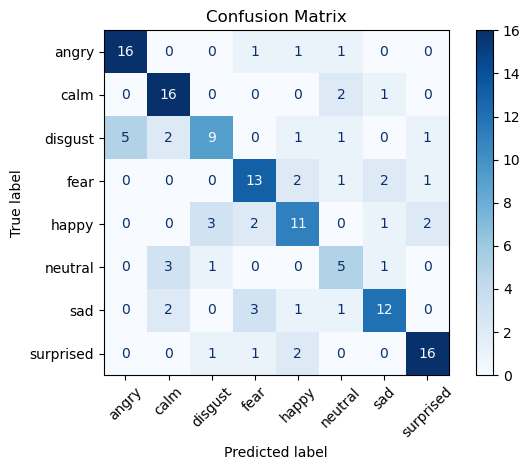

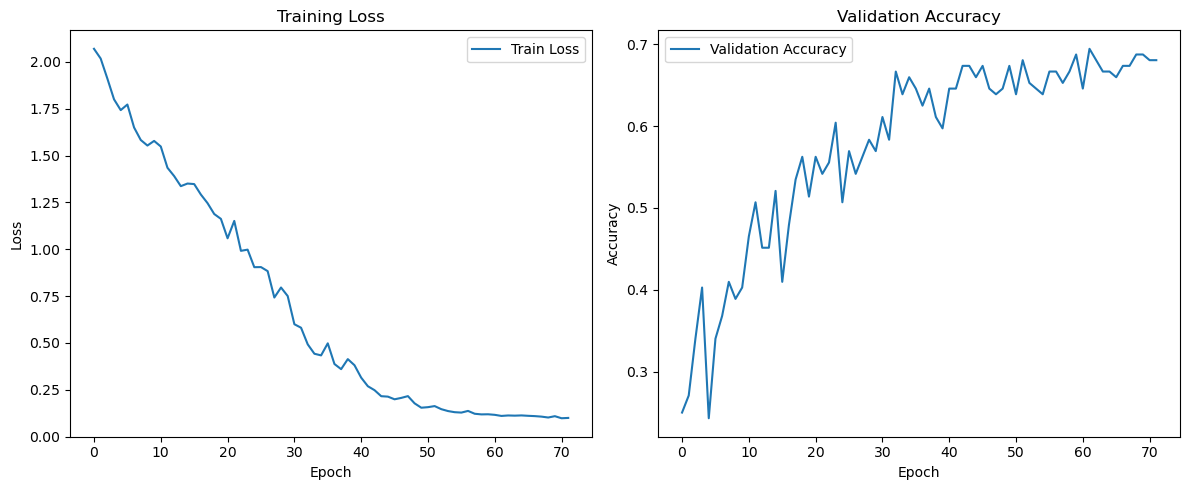

In [30]:
df = load_dataset(DATASET_PATH)
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


all_mfcc = []
all_prosodic = []
for path in train_df['path']:
    waveform, sr = torchaudio.load(path)
    if sr != SAMPLE_RATE:
        waveform = T.Resample(sr, SAMPLE_RATE)(waveform)
    mfcc = extract_mfcc_sequence(waveform)
    prosodic = extract_prosodic_features(waveform)
    all_mfcc.append(mfcc.cpu().numpy())
    all_prosodic.append(prosodic.numpy())
all_mfcc_flat = np.concatenate([m for m in all_mfcc], axis=0)
scaler = StandardScaler().fit(all_mfcc_flat)
prosodic_scaler = StandardScaler().fit(np.stack(all_prosodic))

train_dataset = SERDataset(train_df, label_encoder, scaler)
val_dataset = SERDataset(val_df, label_encoder, scaler)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = HybridLSTMTransformer(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

train_model(model, train_loader, val_loader, criterion, optimizer)


In [32]:
from sklearn.metrics import classification_report

# Get predictions and true labels for the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, p, y in val_loader:
        x, p = x.to(device), p.to(device)
        outputs = model(x, p)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.76      0.84      0.80        19
        calm       0.70      0.84      0.76        19
     disgust       0.64      0.47      0.55        19
        fear       0.65      0.68      0.67        19
       happy       0.61      0.58      0.59        19
     neutral       0.45      0.50      0.48        10
         sad       0.71      0.63      0.67        19
   surprised       0.80      0.80      0.80        20

    accuracy                           0.68       144
   macro avg       0.67      0.67      0.66       144
weighted avg       0.68      0.68      0.68       144

